<a href="https://colab.research.google.com/github/jnpos/group8_ECG/blob/Experimental-set-up/ECG_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experimental set-up**

## **Load data and packages**

In [15]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

import zipfile
import os
import pandas as pd

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Packages
import numpy as np 
from sklearn import model_selection
from sklearn import preprocessing
from scipy.stats import shapiro
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit


fatal: destination path 'tm10007_ml' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001


## **Split data into input and output**

Niet handiger om preprocessing (incl deleting missing data en scaling) te doen vóór data splitten?

In [2]:
# Find column with label 
bool_cols = [col for col in data 
             if np.isin(data[col].dropna().unique(), [0, 1]).all()]
loc_label = data.columns.get_loc('label')

# Determine data and output 
y = data['label']
x = pd.DataFrame()
x = data.drop(data.columns[loc_label],axis=1)

## **Preprocessing**

**Delete samples with missing data**

In [3]:
deleted_patients = []
zero_samples = []
zero_counts = []

# Find patients (samples) with zero-padded ECG lead(s) (number of zeros for 1 lead = 750)
for i in range(len(x)):
  num_zeros = (x.iloc[i] == 0).sum()
  if (num_zeros/750 >= 1) & (num_zeros%750 == 0):      # control if number of zeros is divisible by 750 and therefore zero-padded missing data and not relevant actual data
    deleted_patients.append(i)
    zero_samples.append("Sample_" + str(i))
    zero_counts.append(num_zeros)

# Delete patients with missing lead data from dataset
x_dropped = x.drop(deleted_patients)
x_dropped = x_dropped.reset_index(drop=True)
y_dropped = y.drop(deleted_patients)
y_dropped = y_dropped.reset_index(drop=True)
table = pd.DataFrame({'Sample ID': zero_samples, 'Zero count': zero_counts})

# Return table from patients that were deleted and give resultant number of samples and columns in final dataset
print(table)
print(f'The number of samples: {len(x_dropped.index)}')
print(f'The number of columns: {len(x_dropped.columns)}')

     Sample ID  Zero count
0   Sample_177         750
1   Sample_251         750
2   Sample_269         750
3   Sample_321         750
4   Sample_323         750
5   Sample_385         750
6   Sample_434         750
7   Sample_446         750
8   Sample_537         750
9   Sample_542         750
10  Sample_575         750
11  Sample_601         750
12  Sample_784         750
13  Sample_790         750
The number of samples: 813
The number of columns: 9000


**Split data in train and test set**

In [4]:
# Split test and trainingsdata and print shape of resulting trainset
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_dropped, y_dropped,test_size=0.25,random_state=0,stratify=y_dropped)

print(f'Shape of training set x_train: {x_train.shape}')

Shape of training set x_train: (609, 9000)


**Scaling**

In [5]:
# Scaling van x_train; N.B. MOET DIT NIET VOOR X_TEST, Y_TRAIN EN Y_TEST OOK GEBEUREN?
scaler = preprocessing.RobustScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train))

**Test if data is normally distributed**

In [6]:
# Checking if data is normally distributed and print result 
amount_normallydistributed = 0

for column in x_train.columns:
  result = shapiro(x_train[column])
  normallydistributed = result.pvalue > 0.05
  amount_normallydistributed += normallydistributed 
  
print(amount_normallydistributed, "features are normally distributed features")

0 features are normally distributed features


## **Feature selection**

**Univariate**

In [7]:
# Apply univariate feature selection and print resulting shape of train dataset
selector = SelectKBest(f_classif, k="all")
selector.fit(x_train,y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

dataframe = pd.DataFrame()
dataframe = selector.pvalues_

# print(len(selector.pvalues_[selector.pvalues_<0.05]))       # waarvoor dient deze regel?

fs = SelectKBest(score_func=f_classif, k=len(selector.pvalues_[selector.pvalues_<0.05]))
X_univariate = fs.fit_transform(x_train, y_train)
print(f'Resulting x_train after univariate feature selection: {X_univariate.shape}')

Resulting x_train after univariate feature selection: (609, 855)


**Elastic Net (EN) regression**

In [8]:
# Apply elastic net regression feature selection and print resulting shape of train dataset
regr_alpha_ = 0.3858647907662583

ENreg = ElasticNet(alpha=regr_alpha_, l1_ratio=0.05).fit(x_train,y_train)
model_ENreg = SelectFromModel(ENreg, prefit=True)
X_ENreg = model_ENreg.transform(x_train)
print(f'Resulting x_train after EN regression feature selection: {X_ENreg.shape}')

Resulting x_train after EN regression feature selection: (609, 172)


## **Feature transformation**

**Principal Component Analysis (PCA)**

In [9]:
# In case of decision tree, feature amount is still too high after univariate feature selection
# Principal Component Analysis is therefore applied to reduce amount of features to smaller amount of components
X_univariate = pd.DataFrame(X_univariate)
n_samples = len(X_univariate)
n_features = len(X_univariate.columns)
n_features = min((n_samples//2), n_features)

p = PCA(n_components=n_features)
p = p.fit(X_univariate)
X_pca = p.transform(X_univariate)

print(f'Resulting x_train after univariate feature selection and PCA feature transformation: {X_pca.shape}')

Resulting x_train after univariate feature selection and PCA feature transformation: (609, 304)


## **Plot learning curves for classifiers with default hyperparameter settings**

**Define performance metric**

In [10]:
# Define f_beta as a performance scorer
# Beta < 1 lends more weight to precision, while beta > 1 favors recall
f_beta = make_scorer(fbeta_score, beta=2)

**Classifiers in combination with univariate feature selection (+ PCA feature transformation for Decision Tree)**

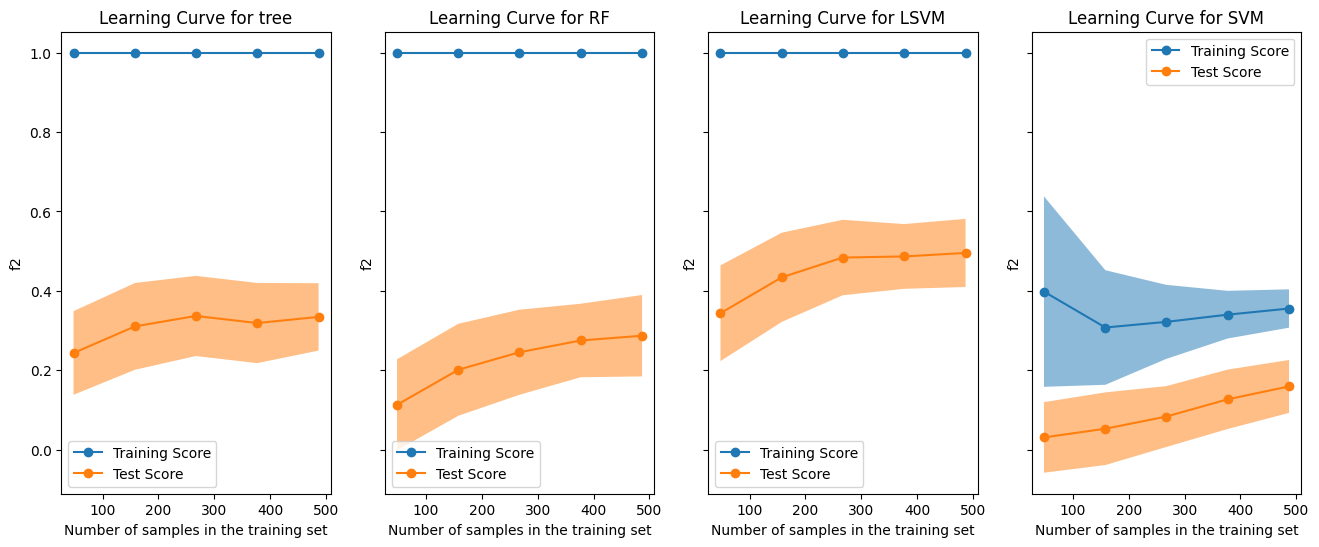

In [13]:
tree = tree.DecisionTreeClassifier(random_state=0)
l_svm = LinearSVC(random_state=0)
svm = svm.SVC(random_state=0)
rf = RandomForestClassifier(random_state=0)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
title = ['tree', 'RF', 'LSVM', 'SVM']

common_params = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

common_params_tree = {
    "X": X_pca,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

LearningCurveDisplay.from_estimator(tree, **common_params_tree, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {title[0]}")

for ax_idx, estimator in enumerate([rf, l_svm, svm],1):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")

**Classifiers in combination with EN regression feature selection**

IndexError: ignored

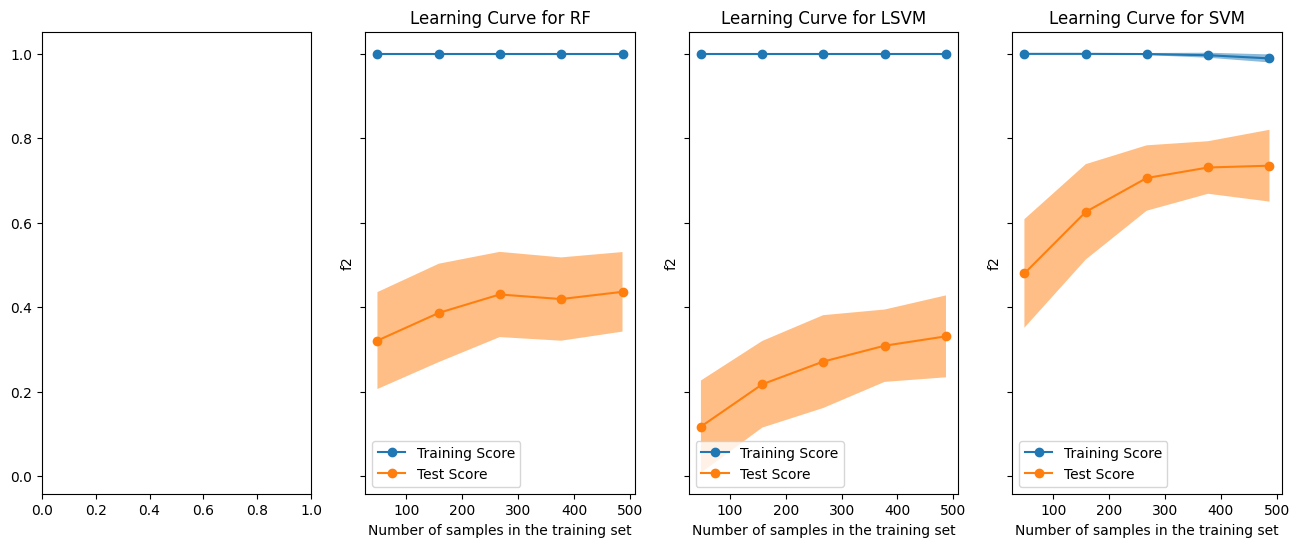

In [16]:
tree = tree.DecisionTreeClassifier(random_state=0)
l_svm = LinearSVC(random_state=0)
svm = svm.SVC(random_state=0)
rf = RandomForestClassifier(random_state=0)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
title = ['tree', 'RF', 'LSVM', 'SVM']

common_params = {
    "X": X_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}


#LearningCurveDisplay.from_estimator(tree, **common_params_tree, ax=ax[0])
#handles, label = ax[0].get_legend_handles_labels()
#ax[0].legend(handles[:2], ["Training Score", "Test Score"])
#ax[0].set_title(f"Learning Curve for {title[0]}")

for ax_idx, estimator in enumerate([tree, rf, l_svm, svm],1):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")

## **Optimize hyperparameter settings**

## **Plot learning curves for classifiers with default hyperparameter settings**

# **Evaluation set-up**